##### Importing required libraries


In [18]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

Load Training Data and count the null values in each column.

In [19]:
df = pd.read_csv('CLC_train.csv')
#Total Null values in each column
null_val = (df[df == -200].count()*100)/df.shape[0]
for i in range(len(df.columns)):
    print("{} : {}".format(df.columns[i],null_val[i]))

df_wn = df[df != -200]

Date : 0.0
Time : 0.0
CO_GT : 17.982631930527724
PT08_S1_CO : 4.315297261189045
NMHC_GT : 89.48563794255178
C6H6_GT : 4.315297261189045
PT08_S2_NMHC : 4.315297261189045
Nox_GT : 17.608550434201735
PT08_S3_Nox : 4.315297261189045
NO2_GT : 17.648630594522377
PT08_S4_NO2 : 4.315297261189045
PT08_S5_O3 : 4.315297261189045
T : 4.315297261189045
RH : 4.315297261189045
AH : 4.315297261189045
CO_level : 0.0


In [20]:
#Too many NA values in 'NHMC_GT'
df_wn.drop(columns=['NMHC_GT'],inplace=True)

Extracting WeekDays from dates

In [21]:
import datetime
dys = ['Monday','Tuesday','Wednesday','Thursday','Friday','Saturday','Sunday']
def dateToDay(x):
    dy = datetime.datetime.strptime(x,'%m/%d/%Y').weekday()
    return dys[dy]
df_wn['Days'] = df_wn['Date'].apply(lambda x: dateToDay(x))
print(df_wn.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7485 entries, 0 to 7484
Data columns (total 16 columns):
Date            7485 non-null object
Time            7485 non-null object
CO_GT           6139 non-null float64
PT08_S1_CO      7162 non-null float64
C6H6_GT         7162 non-null float64
PT08_S2_NMHC    7162 non-null float64
Nox_GT          6167 non-null float64
PT08_S3_Nox     7162 non-null float64
NO2_GT          6164 non-null float64
PT08_S4_NO2     7162 non-null float64
PT08_S5_O3      7162 non-null float64
T               7162 non-null float64
RH              7162 non-null float64
AH              7162 non-null float64
CO_level        7485 non-null object
Days            7485 non-null object
dtypes: float64(12), object(4)
memory usage: 935.8+ KB
None


In [22]:
#Mapping Target variables
co_dict = {'Very low':0,'Low':1,'Moderate':2,'High':3,'Very High':4}
df_wn['CO_level'] = df_wn['CO_level'].map(co_dict)

### Plotting Correlations with each other

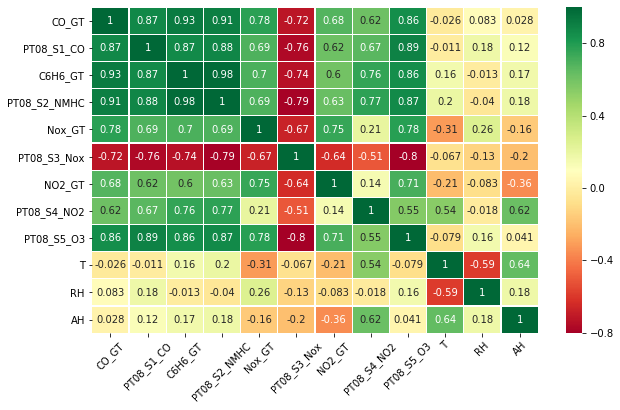

In [23]:
df_won = df_wn.dropna(axis=0)
#Plotting the corr matrix
sns.heatmap(df_won.drop(columns=['Date','Time','CO_level']).corr(),annot=True,cmap='RdYlGn',linewidths=0.2)
fig=plt.gcf()
fig.set_size_inches(10,6)
plt.xticks(rotation=45)
plt.show()

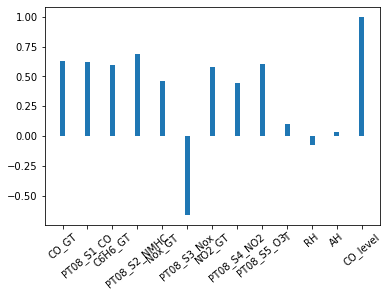

In [24]:
#Correlation of features with CO level
corrDF = df_won.drop(columns=['Date','Time','Days']).corrwith(df_won['CO_level'])
plt.bar(corrDF.index,corrDF.loc[:],width=0.2)
plt.xticks(rotation=40)
plt.show()

#### Plotting avg. CO_GT to understand pollution levels on different weekdays

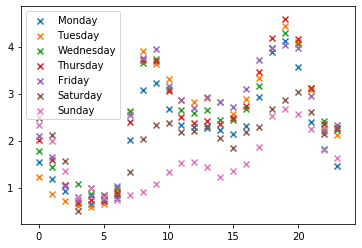

In [25]:
#Plotting the avg. CO_GT levels of each weekday.
monday = df_won[(df_won['Days']==dys[0])][['Time','CO_GT']]
tuesday = df_won[(df_won['Days']==dys[1])][['Time','CO_GT']]
wednesday = df_won[(df_won['Days']==dys[2])][['Time','CO_GT']]
thursday = df_won[(df_won['Days']==dys[3])][['Time','CO_GT']]
friday = df_won[(df_won['Days']==dys[4])][['Time','CO_GT']]
saturday = df_won[(df_won['Days']==dys[5])][['Time','CO_GT']]
sunday = df_won[(df_won['Days']==dys[6])][['Time','CO_GT']]

days = [monday,tuesday,wednesday,thursday,friday,saturday,sunday]

def plotHours(day):
    mapp = day.groupby('Time').CO_GT.mean()
    mapp.index = [x.split(':')[0] for x in mapp.index]
    mapp.index = [int(x) for x in mapp.index]
    plt.scatter(mapp.index,mapp,marker='x')

for day in days:
    plotHours(day)

# print(mapp.head())
plt.legend(dys)

plt.show()

In [26]:
# Imputing some columns with low figures.
# Looking at the data, 'Very Low' CO_level has the most NA values
df_wn.fillna(value={'CO_GT':0,'NO2_GT':50,'Nox_GT':50},inplace=True)
df_won = df_wn.dropna(axis=0)

Looking at the graph of different Weekdays, Weekends have different pollution levels, so we create two bool features 'Weekday' and 'Weekend'

In [27]:
df_won['Weekend'] = df_won['Days'].apply(lambda x: ((x == dys[-1]) | (x == dys[-2])))
df_won['Weekday'] = df_won['Days'].apply(lambda x: not ((x == dys[-1]) | (x== dys[-2])))

### Preparing numpy arrays and feature scaling

In [70]:
X = np.array(df_won[['CO_GT','PT08_S1_CO','Weekend','Weekday','AH','T']])
y = np.array(df_won['CO_level'])

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X = scaler.fit_transform(X)
X_train,X_cv,y_train,y_cv = train_test_split(X,y,test_size=0.2)

print(X_train)

[[ 0.57980888  1.21016581 -0.61856728  0.61856728 -0.45827324  0.55551029]
 [ 0.02516868 -0.20872038  1.61663901 -1.61663901  0.9428613   0.70573638]
 [-0.22133808 -0.47080764 -0.61856728  0.61856728  0.67663301  0.11638787]
 ...
 [-0.15971139 -0.03248929 -0.61856728  0.61856728 -0.45470996  0.31283737]
 [ 0.94956901  0.72666001 -0.61856728  0.61856728 -1.02967144 -0.73874527]
 [ 0.02516868 -0.25390784 -0.61856728  0.61856728  0.3187774   2.21955315]]


### Applying ML frameworks from sklearn

In [71]:
from sklearn.ensemble import RandomForestClassifier

clf = RandomForestClassifier(n_estimators=90,criterion='gini')
clf.fit(X_train,y_train)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=90,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)

##### Getting metrics for seeing the stats

In [72]:
print("Accuracy = {}".format(clf.score(X_cv,y_cv)))
y_pred = clf.predict(X_cv)

from sklearn.metrics import f1_score
from sklearn.metrics import cohen_kappa_score
from sklearn.metrics import confusion_matrix

print("F1 score = {}".format(f1_score(y_cv,y_pred,average='micro')))
print("Kappa score = {}".format(cohen_kappa_score(y_cv,y_pred)))
print("Confusion Matrix :")
print(confusion_matrix(y_cv,y_pred))


Accuracy = 0.9993021632937893
F1 score = 0.9993021632937893
Kappa score = 0.9987712838840119
Confusion Matrix :
[[270   0   0   0   0]
 [  0 239   0   0   0]
 [  0   0  54   0   0]
 [  0   0   0 868   0]
 [  0   0   0   1   1]]


In [73]:
from data_process import data_process
from data_process import generate_scores


test_data = pd.read_csv('CLC_test.csv')
test_data = data_process(test_data)
X_test = np.array(test_data[['CO_GT','PT08_S1_CO','Weekend','Weekday','AH','T']])
y_test = np.array(test_data['CO_level'])

X_test = scaler.transform(X_test)
generate_scores(X_test,y_test,clf)

Accuracy = 0.711864406779661
F1 score = 0.711864406779661
Kappa score = 0.5970028255036195
Confusion Matrix :
[[334   0   0   0   0]
 [ 35 275   0   0   0]
 [  0   0  61   0   0]
 [  0   0 490 632   0]
 [  0   0   0   2   0]]


In [74]:
from sklearn.ensemble import GradientBoostingClassifier
clf = GradientBoostingClassifier(n_estimators=90,learning_rate=0.1)
clf.fit(X_train,y_train)
generate_scores(X_cv,y_cv,clf)
generate_scores(X_test,y_test,clf)

Accuracy = 1.0
F1 score = 1.0
Kappa score = 1.0
Confusion Matrix :
[[270   0   0   0   0]
 [  0 239   0   0   0]
 [  0   0  54   0   0]
 [  0   0   0 868   0]
 [  0   0   0   0   2]]
Accuracy = 0.711864406779661
F1 score = 0.711864406779661
Kappa score = 0.596841008086745
Confusion Matrix :
[[334   0   0   0   0]
 [ 33 273   0   4   0]
 [  0   0  61   0   0]
 [  0   0 490 632   0]
 [  0   0   0   0   2]]


In [75]:
from sklearn.svm import SVC
clf = SVC(C=0.1,kernel='sigmoid')
clf.fit(X_train,y_train)

generate_scores(X_test,y_test,clf)

Accuracy = 0.8032100488485694
F1 score = 0.8032100488485693
Kappa score = 0.6592278644757281
Confusion Matrix :
[[206  62   0   2   0]
 [101 135   2   1   0]
 [ 34  18   0   2   0]
 [ 34  24   0 810   0]
 [  0   0   0   2   0]]
Accuracy = 0.3723346090759978
F1 score = 0.3723346090759978
Kappa score = 0.1639576247498472
Confusion Matrix :
[[196 136   1   1   0]
 [115 189   6   0   0]
 [ 20  32   0   9   0]
 [437 389   0 296   0]
 [  0   0   0   2   0]]


In [76]:
from sklearn.ensemble import AdaBoostClassifier
clf = AdaBoostClassifier(learning_rate=0.1)
clf.fit(X_train,y_train)
generate_scores(X_cv,y_cv,clf)
generate_scores(X_test,y_test,clf)

Accuracy = 0.9986043265875785
F1 score = 0.9986043265875785
Kappa score = 0.9975407416560265
Confusion Matrix :
[[270   0   0   0   0]
 [  0 239   0   0   0]
 [  0   0  54   0   0]
 [  0   0   0 868   0]
 [  0   0   0   2   0]]
Accuracy = 0.7129579004920722
F1 score = 0.7129579004920722
Kappa score = 0.5985402833139757
Confusion Matrix :
[[334   0   0   0   0]
 [ 33 277   0   0   0]
 [  0   0  61   0   0]
 [  0   0 490 632   0]
 [  0   0   0   2   0]]
